In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import linregress
import pandas as pd

In [4]:
def get_butter_filter_and_rmse(data, fc_list, fs, order):
    """
    Performs Steps 1 and 2: Filters data over a range of cutoffs and calculates RMSE.
    """
    nyquist = 0.5 * fs
    rmse_values = []

    def butter_lowpass_filter(data, cutoff, order):
        if cutoff >= nyquist:
            return data
        normalized_cutoff = cutoff / nyquist
        b, a = butter(order, normalized_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    def calculate_rmse(raw, filtered):
        return np.sqrt(np.mean((raw - filtered)**2))

    for fc in fc_list:
        filtered_data = butter_lowpass_filter(data, fc, order)
        rmse = calculate_rmse(data, filtered_data)
        rmse_values.append(rmse)

    return np.array(rmse_values)

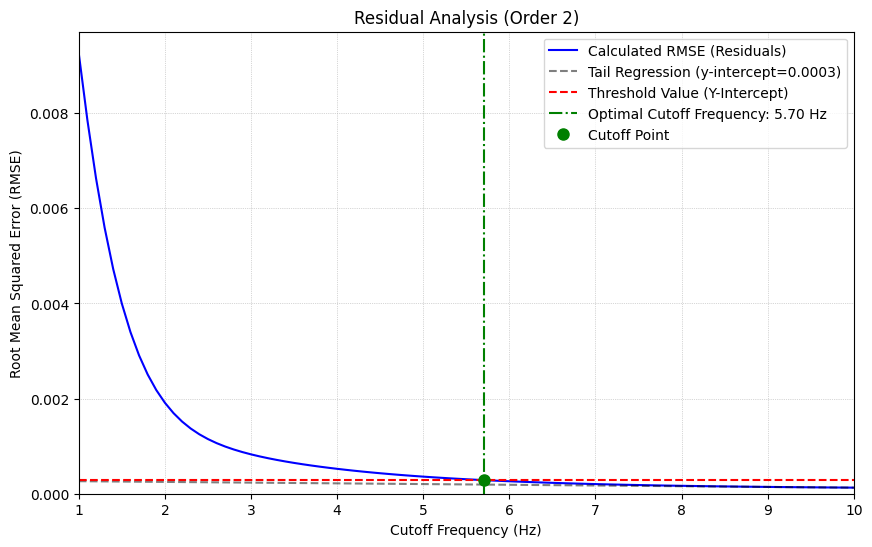


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9983
Threshold Value (Noise Floor): 0.0003
Calculated Optimal Cutoff Frequency: 5.70 Hz


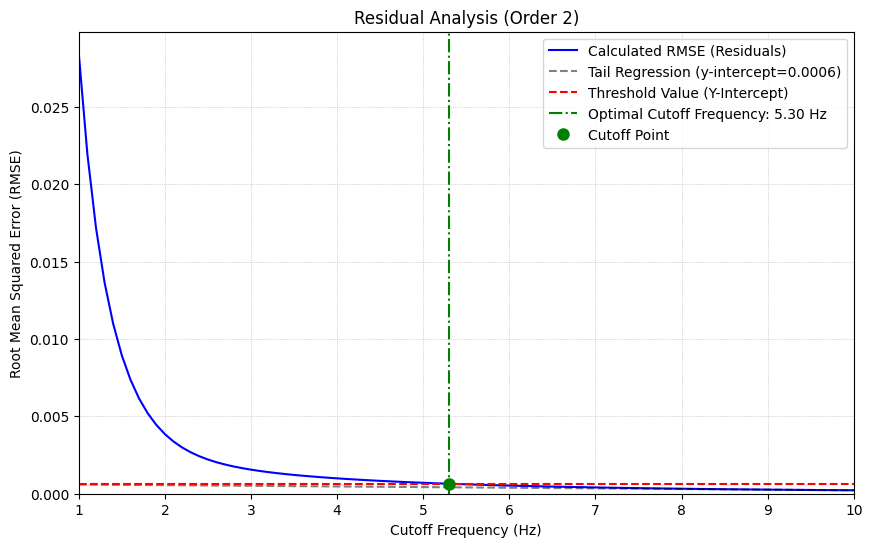


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9988
Threshold Value (Noise Floor): 0.0006
Calculated Optimal Cutoff Frequency: 5.30 Hz


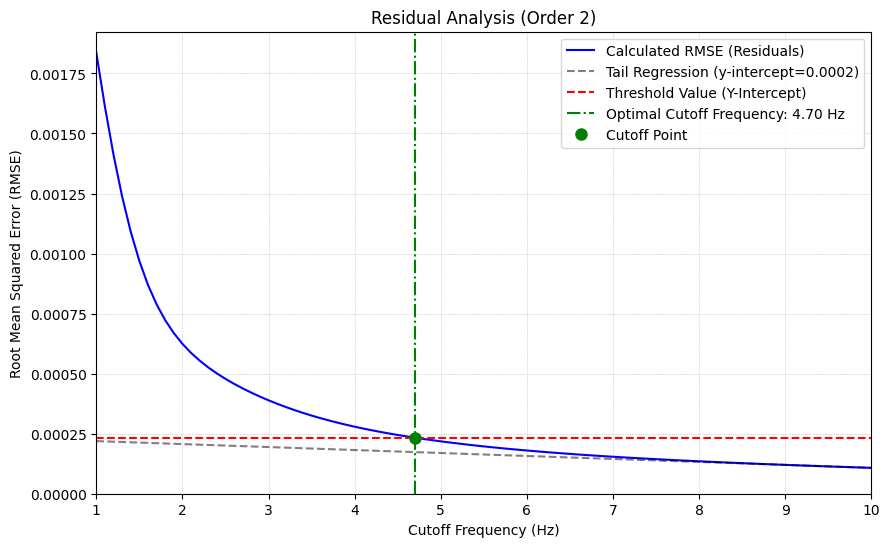


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9997
Threshold Value (Noise Floor): 0.0002
Calculated Optimal Cutoff Frequency: 4.70 Hz


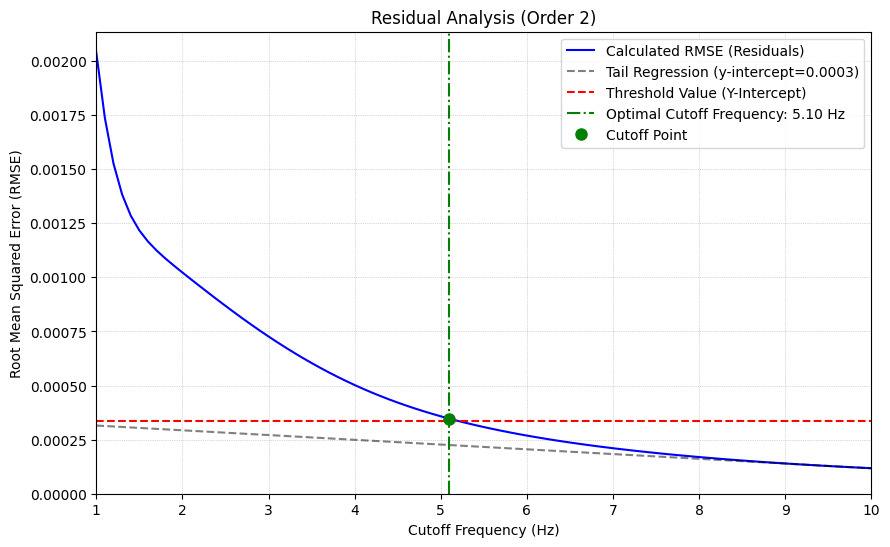


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9992
Threshold Value (Noise Floor): 0.0003
Calculated Optimal Cutoff Frequency: 5.10 Hz


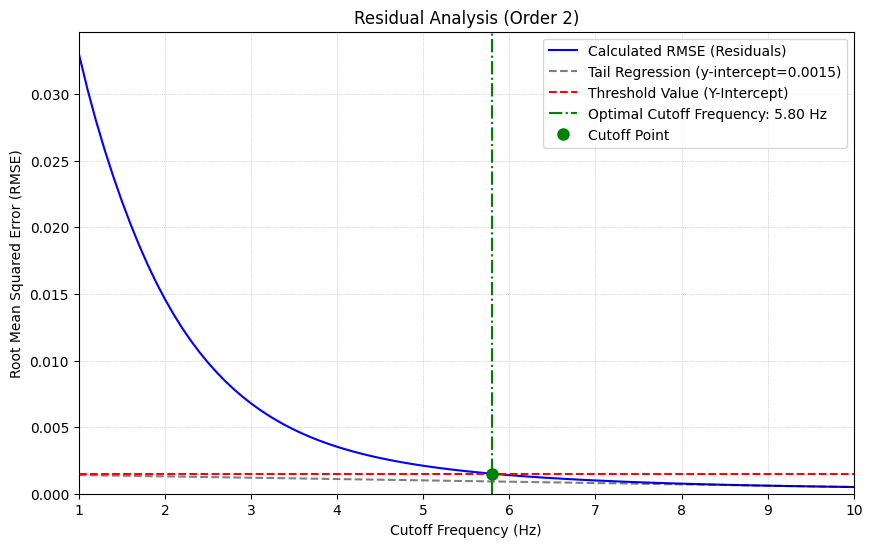


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9985
Threshold Value (Noise Floor): 0.0015
Calculated Optimal Cutoff Frequency: 5.80 Hz


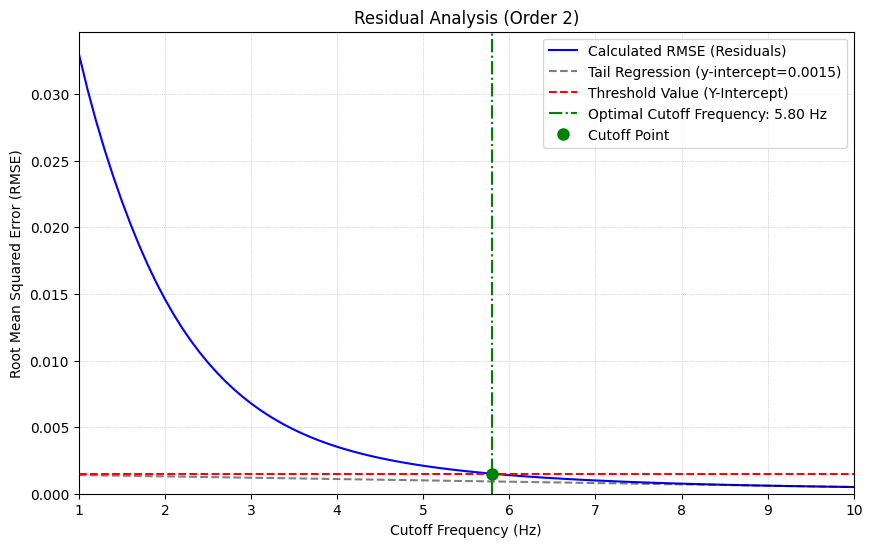


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9985
Threshold Value (Noise Floor): 0.0015
Calculated Optimal Cutoff Frequency: 5.80 Hz


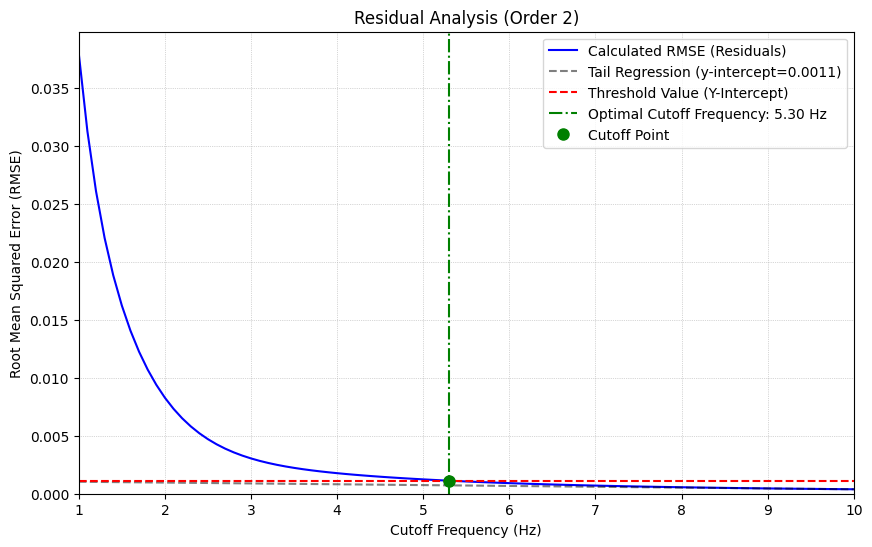


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9988
Threshold Value (Noise Floor): 0.0011
Calculated Optimal Cutoff Frequency: 5.30 Hz


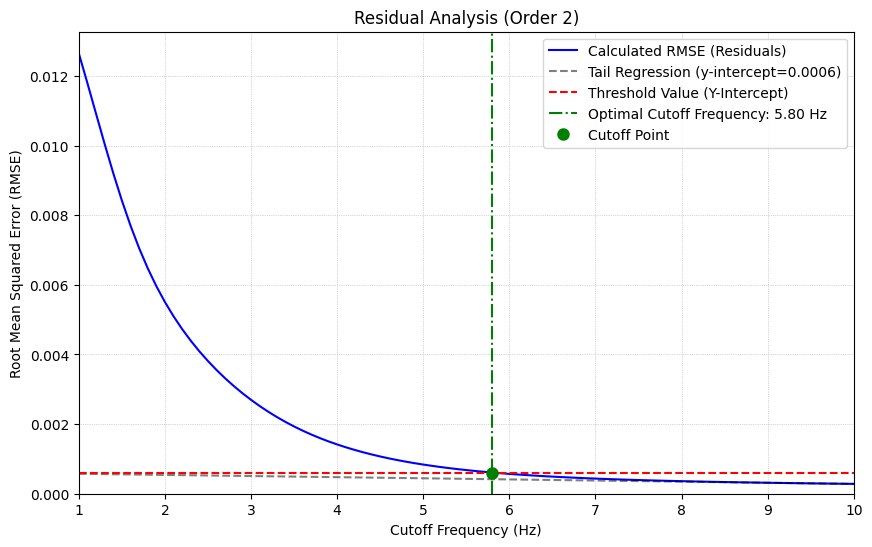


--- Analysis Summary ---
Sampling Frequency (FS): 100 Hz
Tail Regression Start: 9.0 Hz
R-Value: 0.9992
Threshold Value (Noise Floor): 0.0006
Calculated Optimal Cutoff Frequency: 5.80 Hz


In [5]:
# 1. Your raw, unfiltered data array (e.g., from a sensor)
# NOTE: Replace this placeholder with your actual loaded data array
# Example placeholder:
FS = 100        # Sampling Frequency (Hz)

gait_data = pd.read_csv('Trial0003_str11.tsv', delimiter='\t', header=10)
plank_data = pd.read_csv('Trial0016_Plank_Leg_arm_raise.tsv', delimiter='\t', header=10)

ankle_x_plank = plank_data['10 - L_Ankle X'] / 1000
ankle_z_plank = plank_data['10 - L_Ankle Z'] / 1000

hip_x_plank = plank_data['14 - R_Hip X'] / 1000
hip_z_plank = plank_data['14 - R_Hip Z'] / 1000

ankle_x_gait = gait_data['10 - L_Ankle Z'] / 1000
ankle_z_gait = gait_data['10 - L_Ankle Z'] / 1000

hip_x_gait = gait_data['14 - R_Hip X'] / 1000
hip_z_gait = gait_data['14 - R_Hip Z'] / 1000

data = [ankle_x_plank, ankle_z_plank, hip_x_plank, hip_z_plank, ankle_x_gait, ankle_z_gait, hip_x_gait, hip_z_gait]


for element in data:

    # 2. Analysis Parameters
    MIN_FREQ = 1.0     # Start of the frequency sweep (Hz)
    MAX_FREQ = 10.0    # End of the frequency sweep (Hz)
    STEP_FREQ = 0.1    # Interval between tests (Hz)
    FILTER_ORDER = 2   # The order of the Butterworth filter
    TAIL_REGRESSION_START_FREQ = 9.0 # Frequency at which the 'tail' line fitting begins
    SEARCH_START_FREQ = 2.0          # Frequency to begin searching for the 'knee' (to ignore initial high RMSE)


    # Define the full range of frequencies to test
    cutoff_frequencies = np.arange(MIN_FREQ, MAX_FREQ + STEP_FREQ/2, STEP_FREQ)

    # 1) & 2) Filter and Calculate RMSE
    rmse_values = get_butter_filter_and_rmse(element, cutoff_frequencies, FS, FILTER_ORDER)

    # 4) Residual Plot Tail Regression
    # --- Define Tail Range ---
    tail_mask = cutoff_frequencies >= TAIL_REGRESSION_START_FREQ
    tail_freqs = cutoff_frequencies[tail_mask]
    tail_rmse = rmse_values[tail_mask]

    # --- Fit Line (Linear Regression) ---
    slope, intercept, r_value, _, _ = linregress(tail_freqs, tail_rmse)

    threshold_value = intercept
    tail_fit_line = slope * cutoff_frequencies + intercept # Full regression line for plotting

    # 5) Determine Cutoff Frequency
    # We find the LAST frequency (the 'knee') where the RMSE is ABOVE the noise floor.
    search_mask = cutoff_frequencies >= SEARCH_START_FREQ
    search_rmse = rmse_values[search_mask]

    indices_above_threshold_in_search = np.where(search_rmse > threshold_value)[0]

    if len(indices_above_threshold_in_search) > 0:
        # Get the index of the LAST point above the threshold in the search subset
        fc_optimal_search_index = indices_above_threshold_in_search[-1]

        # Calculate the starting offset index using integer arithmetic (to avoid float issues)
        start_offset_index = int(np.round((SEARCH_START_FREQ - MIN_FREQ) / STEP_FREQ))

        # Calculate the final index in the full list
        fc_optimal_index = start_offset_index + fc_optimal_search_index

        fc_optimal = cutoff_frequencies[fc_optimal_index]
        fc_optimal_rmse = rmse_values[fc_optimal_index]
    else:
        fc_optimal = SEARCH_START_FREQ
        fc_optimal_rmse = rmse_values[np.argmin(np.abs(cutoff_frequencies - fc_optimal))]
        print("Warning: RMSE never clearly exceeded the threshold in the search range.")

    # 3) Plotting the Results
    plt.figure(figsize=(10, 6))

    # Plot the calculated RMSE values (Blue Solid Line)
    plt.plot(cutoff_frequencies, rmse_values, 'b-', label='Calculated RMSE (Residuals)')

    # Plot the fitted tail line (Gray Dashed Line)
    plt.plot(cutoff_frequencies, tail_fit_line, 'k--', alpha=0.5, label=f'Tail Regression (y-intercept={threshold_value:.4f})')

    # Plot the Threshold Value (Red Dashed Line)
    plt.axhline(threshold_value, color='r', linestyle='--', label=f'Threshold Value (Y-Intercept)')

    # Highlight the Optimal Cutoff Frequency
    plt.axvline(fc_optimal, color='g', linestyle='-.', label=f'Optimal Cutoff Frequency: {fc_optimal:.2f} Hz')
    plt.plot(fc_optimal, fc_optimal_rmse, 'go', markersize=8, label=f'Cutoff Point')

    # Final plot formatting
    plt.title(f'Residual Analysis (Order {FILTER_ORDER})')
    plt.xlabel('Cutoff Frequency (Hz)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.xlim(MIN_FREQ, MAX_FREQ)
    plt.ylim(ymin=0)
    plt.show()

    print(f"\n--- Analysis Summary ---")
    print(f"Sampling Frequency (FS): {FS} Hz")
    print(f"Tail Regression Start: {TAIL_REGRESSION_START_FREQ} Hz")
    print(f"R-Value: {np.abs(r_value):.4f}")
    print(f"Threshold Value (Noise Floor): {threshold_value:.4f}")
    print(f"Calculated Optimal Cutoff Frequency: {fc_optimal:.2f} Hz")

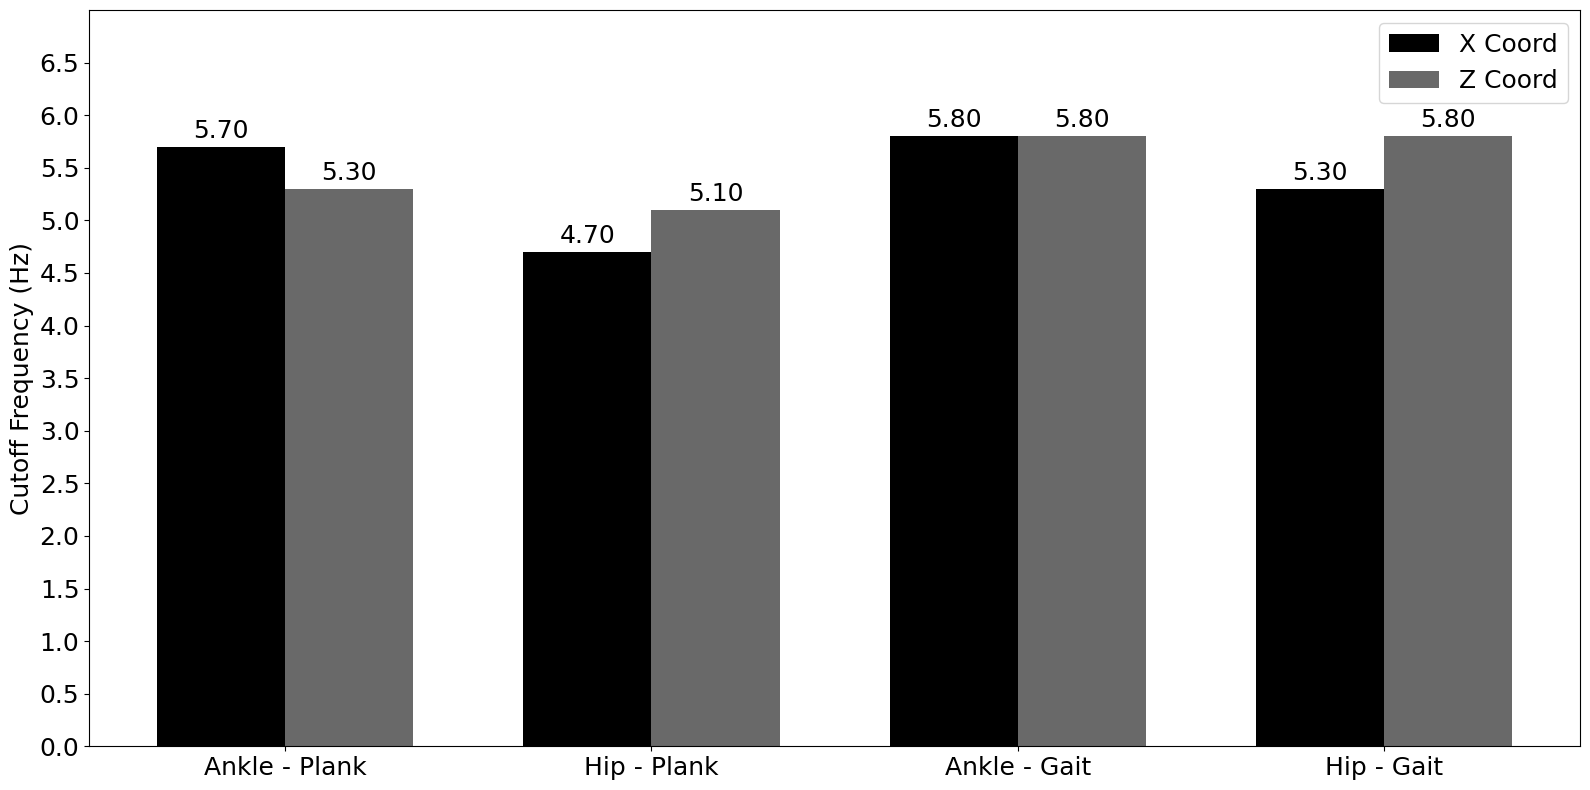

In [8]:
# Data Structure:
# Key = Anatomical Point Name (for X-axis label)
# Value = [Cutoff Frequency for X Coord, Cutoff Frequency for Z Coord]

CUTOFF_DATA = {
    "Ankle - Plank": [5.70, 5.30],
    "Hip - Plank": [4.70, 5.10],
    "Ankle - Gait": [5.80, 5.80],
    "Hip - Gait": [5.30, 5.80]
}

# Coordinate Labels (Fixed for X and Z as requested)
COORD_LABELS = ["X Coord", "Z Coord"]

# Optional: Define colors
COLOR_X = 'black'
COLOR_Z = 'dimgray'

# 1. Extract Categories (X-axis labels)
categories = list(CUTOFF_DATA.keys())
num_points = len(categories)

# 2. Extract Data Arrays for Plotting
# Note: We use list comprehension and array transposition for clean extraction
all_data = np.array(list(CUTOFF_DATA.values()))

# Coordinate X data is the first column (index 0)
coord_X_data = all_data[:, 0]
# Coordinate Z data is the second column (index 1)
coord_Z_data = all_data[:, 1]

# Plot settings
bar_width = 0.35
x = np.arange(num_points) # Positions for the groups of bars

fig, ax = plt.subplots(figsize=(4 * num_points, 8)) # Dynamic figure size

# Define positions for the two bars in each group
rects_X = ax.bar(x - bar_width/2, coord_X_data, bar_width, label=COORD_LABELS[0], color=COLOR_X)
rects_Z = ax.bar(x + bar_width/2, coord_Z_data, bar_width, label=COORD_LABELS[1], color=COLOR_Z)

# --- Customize Plot ---

# Y-Axis Setup
ax.set_ylabel('Cutoff Frequency (Hz)', fontsize=18)
ax.set_ylim(0, 7.0)
ax.set_yticks(np.arange(0, 7.0, 0.5))
# Add this line to increase the font size of the tick labels (the numbers)
ax.tick_params(axis='y', labelsize=18)

# X-Axis Setup
# ax.set_xlabel('Anatomical Point', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=18)

# Add a title and legend
# ax.set_title('Optimal Cutoff Frequencies by Coordinate', fontsize=14)
ax.legend(fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Add the frequency value on top of each bar for clarity
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=18)

autolabel(rects_X)
autolabel(rects_Z)

plt.tight_layout()
plt.grid(False)
plt.show()